In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional Burgers equation

Here we will solve the PDE

$$\begin{cases} \partial_t v + v \partial_x v - \nu \partial_x^2 v = 0, & (x,t) \in (0,1) \times (0,1] \\ v(x,0) = u(x), & x \in (0,1) \\ v(0,t) = v(1,t) = 0, & t \in [0,1]\end{cases}$$

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [4]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [32]:
ROOT = "."
assert os.path.isfile(ROOT+"/burgers_1d.ipynb")

In [33]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'cuda'

In [7]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-v0_8-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

Using the [Cole-Hopf transform](https://www.iist.ac.in/sites/default/files/people/IN08026/Burgers_equation_viscous.pdf) we have that 
$$v(x,t) = \frac{\int_{-\infty}^\infty f(\eta) \frac{x-\eta}{t} \exp\left(-\frac{(x-\eta)^2}{4 \nu t}\right) \mathrm{d} \eta}{\int_{-\infty}^\infty f(\eta) \exp\left(-\frac{(x-\eta)^2}{4 \nu t}\right) \mathrm{d} \eta}$$
where $f(x) = \exp\left(-\frac{1}{2\nu} \int_0^x u(y) \mathrm{d} y\right)$. 

We will randomly generate
$$u(x)  = 2 \nu \sum_{k=1}^P a_k \sin (k \pi x) 1_{[0,1]}(x)$$
where $a_1,\dots,a_P \overset{\mathrm{IID}}{\sim} \mathcal{N}(0,1)$.
This gives
$$f(x) = \begin{cases}
    0, & x<0 \\
    \exp\left(-\sum_{k=1}^P \frac{a_k}{\pi k} (1-\cos (k \pi x))\right), & x \in [0,1] \\ 
    \exp\left(-\sum_{k=1}^P \frac{a_k}{\pi k} (1-\cos (k \pi))\right), & x > 1
\end{cases}$$

We use [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature) to numerically approximate the two integrals. To do so, we make the change of variables $z = (x-\eta)/\sqrt{4 \nu t}$ we have $\eta=x-\sqrt{4 \nu t}z$ and $\partial \eta/\partial z = -\sqrt{4 \nu t}$ so 
$$v(x,t) = \sqrt{4 \nu} \frac{\int_{-\infty}^\infty f(x-\sqrt{4 \nu t}z) \frac{z}{\sqrt{t}} \exp\left(-z^2\right) \mathrm{d} z}{\int_{-\infty}^\infty f(x-\sqrt{4 \nu t}z) \exp\left(-z^2\right) \mathrm{d} z}$$


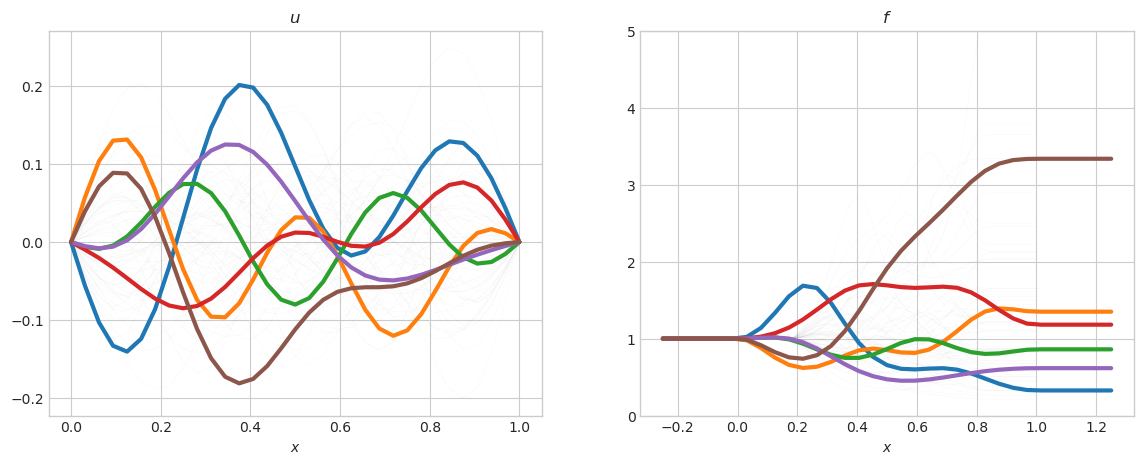

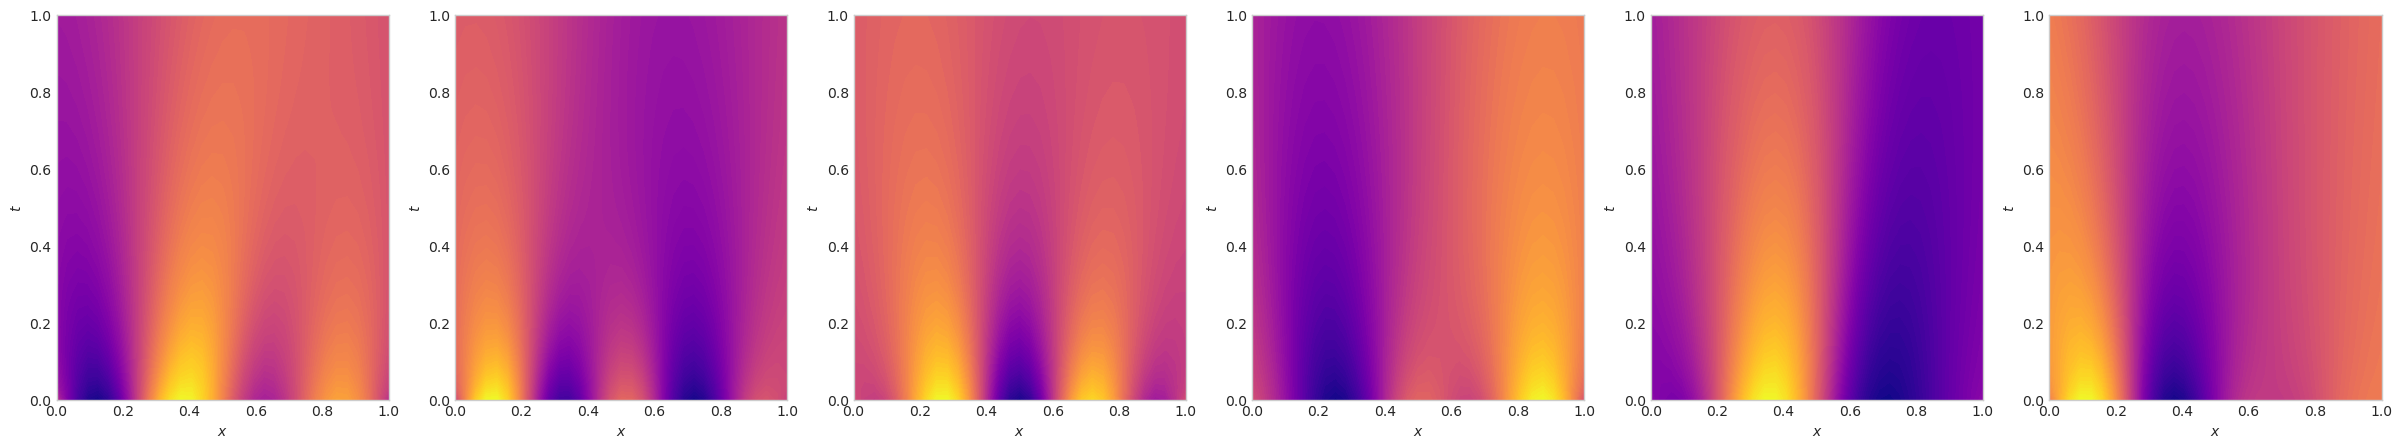

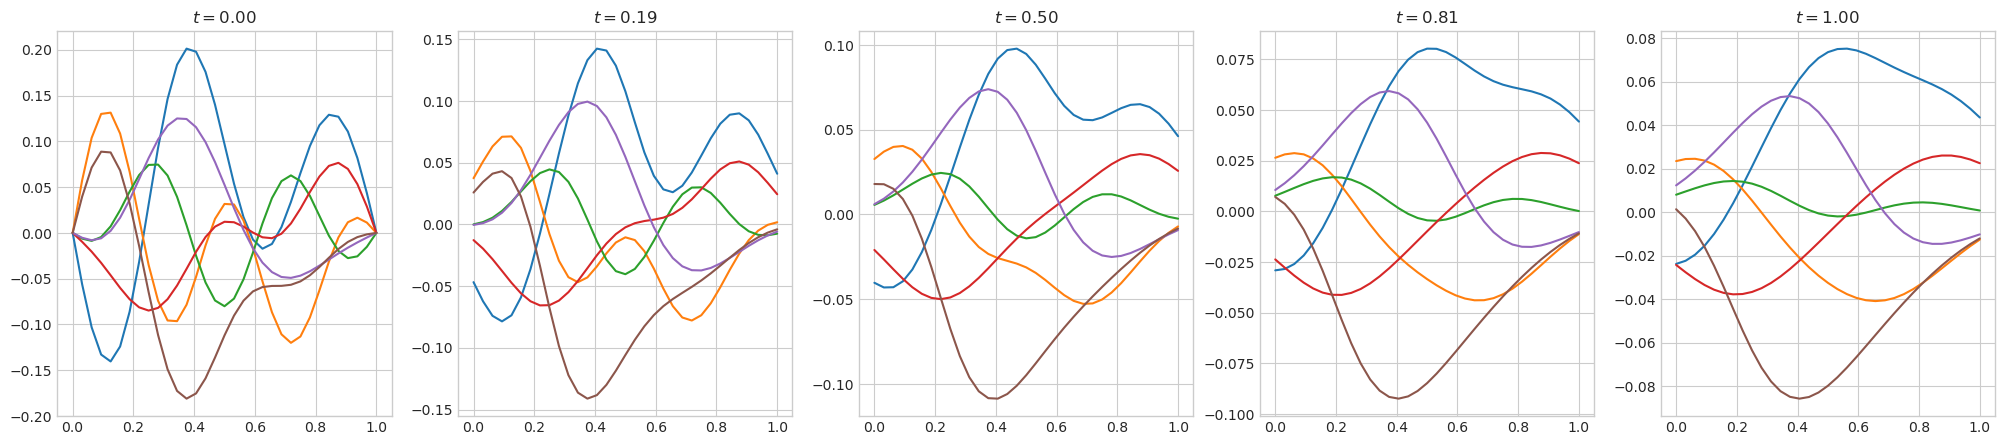

In [31]:
NU = 0.02
P = 5
R = 2**6#2**11
GHDEG = 100
nxticks = 33
ntticks = 33
xticks = torch.linspace(0,1,nxticks,device=DEVICE)
tticks = torch.linspace(0,1,ntticks,device=DEVICE)
xmesh,tmesh = torch.meshgrid(xticks,tticks,indexing="ij")
a = torch.from_numpy(qp.Gaussian(qp.DigitalNetB2(P,seed=7)).gen_samples(R)).to(DEVICE)
k = torch.arange(1,P+1,device=DEVICE)
# k = torch.arange(2,P+2,device=DEVICE)
# a = torch.ones((R,P),dtype=torch.float,device=DEVICE)/(2*NU)
def u_func(x):
    y = 2*NU*a[:,:,None]*torch.sin(torch.pi*k[:,None]*x)
    #y = a[:,:,None]*torch.sin(torch.pi*k[:,None]*x)
    return y.sum(1)
u = u_func(xticks) 
def f_func(x):
    x = torch.clamp(x,min=0,max=1)
    y = -a[:,:,None]/(torch.pi*k[:,None])*(1-torch.cos(k[:,None]*torch.pi*x))
    #y = -a[:,:,None]/(2*NU*torch.pi*k[:,None])*(1-torch.cos(k[:,None]*torch.pi*x))
    return torch.exp(y.sum(1))
gh_pts,gh_weights = np.polynomial.hermite.hermgauss(GHDEG) 
gh_pts,gh_weights = torch.from_numpy(gh_pts).to(DEVICE),torch.from_numpy(gh_weights).to(DEVICE)
deltamesh = xmesh[:,:,None]-torch.sqrt(4*NU*tmesh[:,:,None])*gh_pts
fmesh = f_func(deltamesh.flatten()).reshape((-1,*deltamesh.shape))
denom = (fmesh*gh_weights).sum(-1)
numer = (fmesh*gh_pts/torch.sqrt(tmesh[:,:,None])*gh_weights).sum(-1)
vticks = np.sqrt(4*NU)*numer/denom
vticks[:,:,0] = u
plt_highlights = 6
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].set_title(r"$u$")
ax[0].set_xlabel(r"$x$")
ax[0].plot(xticks.cpu(),u.T.cpu(),linewidth=LWTHIN,color="k")
ax[0].plot(xticks.cpu(),u[:plt_highlights].T.cpu(),linewidth=LW)
xticks_ext = xticks*1.5-.25
f = f_func(xticks_ext)
ax[1].set_title(r"$f$")
ax[1].set_xlabel(r"$x$")
ax[1].plot(xticks.cpu(),f.T.cpu(),linewidth=LWTHIN,color="k")
ax[1].plot(xticks_ext.cpu(),f[:plt_highlights].T.cpu(),linewidth=LW);
ax[1].set_ylim([0,5])
fig.show()
fig,ax = pyplot.subplots(nrows=1,ncols=plt_highlights,figsize=(5*plt_highlights,5))
for i in range(plt_highlights):
    ax[i].contourf(xmesh.cpu(),tmesh.cpu(),vticks[i].cpu(),cmap=cm.plasma,levels=100)
    ax[i].set_xlabel(r"$x$"); ax[i].set_ylabel(r"$t$")
fig.show()
tpltidxs = [0,ntticks//5,ntticks//2,4*ntticks//5,ntticks-1]
fig,ax = pyplot.subplots(nrows=1,ncols=len(tpltidxs),figsize=(5*len(tpltidxs),5))
for i,tiplt in enumerate(tpltidxs):
    ax[i].set_title(r"$t = %.2f$"%tticks[tiplt])
    ax[i].plot(xticks.cpu(),vticks[:plt_highlights,:,tiplt].T.cpu())

## GP for PDE Solves

In [9]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

In [10]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=1e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant

In [11]:
import os 
os.listdir()

['NORIS_small_fp64',
 'elliptic_pde_1d_data.small.npz',
 '.ipynb_checkpoints',
 'elliptic_pde_1d.ipynb']

iter avg l2rerrs: [1.00000000e+00 1.81175572e+00 9.71228368e-01 4.47811264e-01
 1.69019614e-01 4.91876909e-02 1.04784132e-02 1.78308535e-03
 5.26529701e-04 4.31639734e-04 4.30788098e-04]


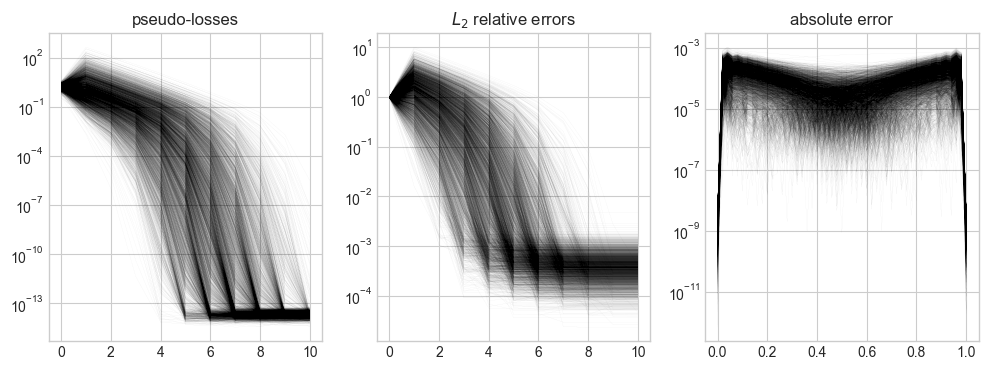

In [12]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "%s/%s.%s"%(ROOT,"elliptic_pde_1d_data",tag)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks)),
            "l2relerrors": np.empty((R,maxiter+1)),
            "L_chols": np.empty((R,maxiter,ki.ntot,ki.ntot))}
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//8
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = True,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(data_r["zhist"][:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])).numpy()
            data["L_chols"][r] = data_r["L_chol_hist"].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(precision=1,threshold=8):
                    print(data["l2relerrors"][r])
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["l2relerrors"]),
        torch.from_numpy(data["L_chols"]))
maxiter = 10
vopt,losses_opt,l2rerrs,L_chols = get_data(maxiter=maxiter,tag="small",force_gen=False)
print("iter avg l2rerrs:",l2rerrs.mean(0).numpy())
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
ax[0].set_title("pseudo-losses")
ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
ax[1].set_yscale("log",base=10)
ax[2].set_title("absolute error")
ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
ax[2].set_yscale("log",base=10);

/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:140
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:140


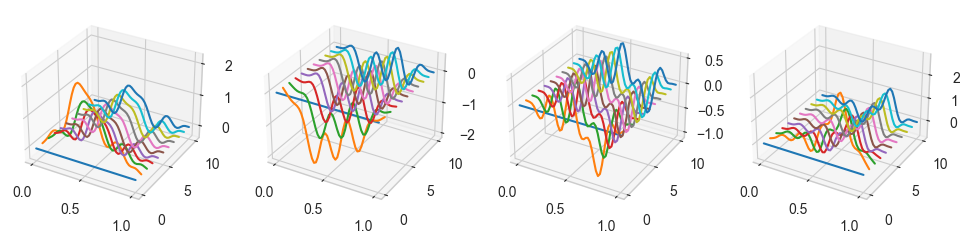

In [13]:
plt_idxs = [0,1,2,3]
ncols = len(plt_idxs)
fig = pyplot.figure(figsize=(12,4))
ax = np.empty(ncols,dtype=object)
_gs = gridspec.GridSpec(1,ncols)
for i in range(ncols): ax[i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(ncols):
    for k in range(vopt.size(1)):
        ax[i].plot(xticks,k*torch.ones_like(xticks),vopt[plt_idxs[i],k,:nxticks])

## Training and Validation Dataloaders

In [14]:
val_frac = 1/16
tv_idx = torch.arange(R)#torch.from_numpy(dnb2.rng.permutation(R))
n_train = R-int(val_frac*R)
n_val = R-n_train
tidx = tv_idx[:n_train]
vidx = tv_idx[n_train:]
print("number train u: %d"%n_train)
print("number val   u: %d\n"%n_val)
uticks_train = uticks[tidx]
uticks_val = uticks[vidx]
vopt_train = vopt[tidx]
vopt_val = vopt[vidx]
vticks_train = vticks[tidx]
vticks_val = vticks[vidx]
L_chols_train = L_chols[tidx]
L_chols_val = L_chols[vidx]
print("uticks_train.shape:",tuple(uticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("uticks_val.shape:",tuple(uticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("L_chols_val.shape:",tuple(L_chols_val.shape))

number train u: 3840
number val   u: 256

uticks_train.shape: (3840, 51)
vopt_train.shape: (3840, 11, 104)
vticks_train.shape: (3840, 51)
L_chols_train.shape: (3840, 10, 53, 53)

uticks_val.shape: (256, 51)
vopt_val.shape: (256, 11, 104)
vticks_val.shape: (256, 51)
L_chols_val.shape: (256, 10, 53, 53)


In [15]:
class DatasetCHONKNORIS(torch.utils.data.Dataset):
    def __init__(self, v, L_chols, device="cpu", steps="all", fp32=False, interior_only=False):
        self.v = v[:,:,:nxticks] if interior_only else v
        self.L_chols = L_chols
        if fp32:
            self.v = self.v.to(torch.float32)
            self.L_chols = self.L_chols.to(torch.float32)
        steps = self.L_chols.size(1) if steps=="all" else steps
        self.i_r,self.i_k = torch.cartesian_prod(torch.arange(self.L_chols.size(0)),torch.arange(steps)).T
        self._put_on_device(device)
    def _put_on_device(self, device):
        self.i_r,self.i_k = self.i_r.to(device),self.i_k.to(device)
        self.v,self.L_chols = self.v.to(device),self.L_chols.to(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik = self.i_r[i],self.i_k[i]
        return self.v[ir,ik,:],self.L_chols[ir,ik,:]
    def __len__(self):
        return len(self.i_r)
dataset_train = DatasetCHONKNORIS(vopt_train,L_chols_train,device=DEVICE,steps=maxiter,fp32=True,interior_only=True)
dataset_val = DatasetCHONKNORIS(vopt_val,L_chols_val,device=DEVICE,steps=maxiter,fp32=True,interior_only=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=len(dataset_val),collate_fn=tuple,shuffle=False)

## Neural Operator

### MLP

In [16]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, mlp_layer_nodes:list, activation_function:torch.nn.Module=torch.nn.Tanh(), activate_last_layer:bool=False, scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None, batch_norm=None):
        super().__init__()
        num_layers = len(mlp_layer_nodes)-1
        self.mlp_layer_nodes = mlp_layer_nodes
        self.output_nodes = self.mlp_layer_nodes[-1]
        layers = []
        use_batch_norm = (batch_norm is not None) and (batch_norm is not False)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",".*Initializing zero-element tensors is a no-op*") # occurs when setting a layer with 0 inputs
            for i in range(num_layers):
                layer = torch.nn.Linear(self.mlp_layer_nodes[i],self.mlp_layer_nodes[i+1])
                if callable(weight_init_scheme):
                    weight_init_scheme(layer.weight)
                layer.bias.data.fill_(0. if self.mlp_layer_nodes[i]>0 else 1.)
                if use_batch_norm: 
                    if callable(batch_norm):
                        batch_norm_layer = batch_norm(self.mlp_layer_nodes[i+1])
                    else:
                        batch_norm_layer = torch.nn.BatchNorm1d(self.mlp_layer_nodes[i+1])
                    layers.extend([layer,batch_norm_layer,activation_function])
                else:
                    layers.extend([layer,activation_function])
        if use_batch_norm:
            self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-2]))
        else:    
            self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-1]))
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def forward(self, x):
        x = self.mlp_sequential(x).squeeze()
        x = self.output_transform(x)
        return torch.exp(self.logscale)*x+self.bias

### NORIS Lightning

In [17]:
class NORISLightning(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True, loss_metric="KL", pred_inv=True, kl_flip=True, frob_loss_alpha=.5):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
        self.loss_metric = loss_metric.upper()
        self.pred_inv = pred_inv
        self.kl_flip = kl_flip
        self.ftype = self.mlp.mlp_sequential[0].weight.dtype
        self.s0 = self.mlp.mlp_sequential[0].weight.size(1)
        self._tril_i0,self._tril_i1 = torch.tril_indices(nxticks+2,nxticks+2)
        self._diag_i = torch.arange(nxticks+2)
        self.frob_loss_alpha = frob_loss_alpha
        assert 0<self.frob_loss_alpha<1
    def to(self, device):
        super().to(device)
        self.mlp = self.mlp.to(device)
        self._tril_i0,self._tril_i1,self._diag_i = self._tril_i0.to(device),self._tril_i1.to(device),self._diag_i.to(device)
    def forward(self, v):
        assert v.ndim==2
        L_chol_hat = torch.zeros((v.size(0),nxticks+2,nxticks+2),dtype=self.ftype,device=self._tril_i0.device)
        L_chol_hat[:,self._tril_i0,self._tril_i1] = self.mlp(v[:,:self.s0])
        # set diagonal to exp(x-1) if x<1 and leave as x otherwise
        diags = L_chol_hat[:,self._diag_i,self._diag_i]
        diags[diags<1] = torch.exp(diags[diags<1]-1)
        L_chol_hat[:,self._diag_i,self._diag_i] = diags
        return L_chol_hat
    def linsolve(self, v, y, inference_mode=True, return_L_hat=False):
        # v should be (R,n) and y should be (R,N,K) to give L_hat which is (R,N,N) and x which is (R,N,K)
        assert y.dtype==v.dtype
        dtype = v.dtype
        yis1d = y.ndim==1
        if yis1d:
            y = y[:,None]
        assert v.ndim in [1,2] and (v.ndim+1)==y.ndim
        vis1d = v.ndim==1
        if v.ndim==1:
            v = v[None,:]
            y = y[None,:,:]
        assert v.size(0)==y.size(0)
        v,y = v.to(self.ftype),y.to(self.ftype)
        if inference_mode:
            with torch.inference_mode():
                L_hat = self.forward(v)
        else:
            L_hat = self.forward(v)
        if self.pred_inv:
            L_hat_T = torch.transpose(L_hat,-2,-1)
            x = torch.bmm(L_hat_T,torch.bmm(L_hat,y))
        else: 
           x = torch.cholesky_solve(y,L_hat)
        x = x.to(dtype)
        x = x[0] if vis1d else x
        x = x[:,0] if yis1d else x
        if not return_L_hat:
            return x 
        else:
            L_hat = L_hat[0] if vis1d else L_hat 
            return x,L_hat
    def frob_norm(self, L_chol, L_chol_hat):
        assert not self.pred_inv
        ogndim = L_chol.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L_chol = L_chol[None,:,:]
            L_chol_hat = L_chol_hat[None,:,:]
        assert L_chol.ndim==3 and L_chol_hat.ndim==3
        fnorms = torch.sqrt(((L_chol[:,self._tril_i0,self._tril_i1]-L_chol_hat[:,self._tril_i0,self._tril_i1])**2).sum(1))
        return fnorms[0] if ogndim==2 else fnorms 
    def kl_div(self, L_chol, L_hat, kl_flip=None):
        if kl_flip is None: kl_flip = self.kl_flip
        ogndim = L_chol.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L_chol = L_chol[None,:,:]
            L_hat = L_hat[None,:,:]
        assert L_chol.ndim==3 and L_hat.ndim==3
        if self.pred_inv: # eq (C.1) in https://arxiv.org/pdf/2304.01294
            det2_true = 2*torch.log(L_chol.diagonal(dim1=-1,dim2=-2)).sum(-1)
            det2_pred = 2*torch.log(L_hat.diagonal(dim1=-1,dim2=-2)).sum(-1)
            L_chol_T = torch.transpose(L_chol,-2,-1)
            theta = torch.bmm(L_chol,L_chol_T)
            L_hat_T = torch.transpose(L_hat,-2,-1)
            traces = torch.einsum("ijk,ikl,ilj->i",L_hat,theta,L_hat_T)
            kls = 1/2*(-det2_true-det2_pred+traces-L_chol.size(-1))
        else: # https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/
            det2_true = 2*torch.log(L_chol.diagonal(dim1=-1,dim2=-2)).sum(-1)
            det2_pred = 2*torch.log(L_hat.diagonal(dim1=-1,dim2=-2)).sum(-1)
            if kl_flip:
                L_hat_T = torch.transpose(L_hat,-2,-1)
                theta_hat = torch.bmm(L_hat,L_hat_T)
                t = torch.cholesky_solve(theta_hat,L_chol) # more efficient way to do this? 
                traces = t.diagonal(dim1=-1,dim2=-2).sum(-1)
                det_diff = det2_true-det2_pred
            else:
                L_chol_T = torch.transpose(L_chol,-2,-1)
                theta = torch.bmm(L_chol,L_chol_T)
                t = torch.cholesky_solve(theta,L_hat) # more efficient way to do this? 
                traces = t.diagonal(dim1=-1,dim2=-2).sum(-1)
                det_diff = det2_pred-det2_true
            kls = 1/2*(det_diff-L_chol.size(-1)+traces)
        return kls
    def _common_step(self, batch, tag):
        v,L_chol = batch
        L_hat = self.forward(v)
        if self.loss_metric=="FROB": # mean (Frobineous norm)
            loss = torch.mean(self.frob_norm(L_chol,L_hat))
        elif self.loss_metric=="KL": # mean (KL div)
            loss = torch.mean(self.kl_div(L_chol,L_hat))
        elif self.loss_metric=="FROB_KL": # mean ( frob_loss_alpha*(Frobineious norm) + (1-frob_loss_alpha)*(KL div) )
            frobs = self.frob_norm(L_chol,L_hat)
            kls = self.kl_div(L_chol,L_hat)
            loss = torch.mean(2*(self.frob_loss_alpha*frobs+(1-self.frob_loss_alpha)*kls))
        else:
            raise Exception("invalid loss_metric")
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=5e-3,amsgrad=True)
        # if self.trainer.current_epoch>=2000:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

### Training

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = ROOT+"/"
name = "NORIS_small_fp64"
resume = True
mlp = MultilayerPerceptron(
    #mlp_layer_nodes = [2*nxticks+2,500,100,1500,1750,2000,1750,(1+(nxticks+2))*(nxticks+2)//2],
    mlp_layer_nodes = [nxticks,500,1000,(1+(nxticks+2))*(nxticks+2)//2],
    #mlp_layer_nodes = [nxticks,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #mlp_layer_nodes = [2*nxticks+2,250,500,750,1000,1250,(1+(nxticks+2))*(nxticks+2)//2],
    #activation_function = torch.nn.LogSigmoid(),
    activation_function = torch.nn.Tanh(),
    #activation_function = torch.nn.SiLU(),
    #weight_init_scheme = torch.nn.init.kaiming_normal_
    batch_norm = False
)
#mlp = mlp.to(torch.float64)
noris_lightning = NORISLightning(mlp,automatic_optimization=True,loss_metric="KL",pred_inv=True)
assert noris_lightning.ftype==dataset_train.v.dtype
print()
print("number train: %.2e"%len(dataset_train))
print("number val  : %.2e"%len(dataset_val))
print()
print(noris_lightning)
print()
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 200,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_lightning, 
    train_dataloaders = dataloader_train,
    val_dataloaders = dataloader_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_small_fp64/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./NORIS_small_fp64/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/NORIS_small_fp64/csv/checkpoints/epoch=199-step=27750.ckpt

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 2.0 M  | train
------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.838     Total estimate


number train: 3.84e+04
number val  : 2.56e+03

NORISLightning(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=51, out_features=500, bias=True)
      (1): Tanh()
      (2): Linear(in_features=500, out_features=1000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1000, out_features=1431, bias=True)
    )
  )
)



Sanity Checking: |                                                                                            …

/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=200` reached.


In [19]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics
parsed_metrics = {
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
}
metrics = pd.DataFrame(parsed_metrics)
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.set_title(r"Loss")
epochs = len(metrics.index)
plt_epochs = metrics.index#[epochs//10:]
ax.plot(plt_epochs,metrics["val_loss"][plt_epochs],label="val",linewidth=LW)
ax.plot(plt_epochs,metrics["train_loss"][plt_epochs],label="train",linewidth=LW)
ax.legend()
ax.set_yscale("log",base=10);
metrics.iloc[::max(1,len(metrics)//10)]

FileNotFoundError: [Errno 2] No such file or directory: './/NORIS_small_fp64/csv/metrics.csv'

## Inference

In [20]:
class NORISPrecond(qp.kernel_methods.pcg_module.preconditioners._BasePrecond):
    def __init__(self, v):
        self.v = v
    def solve(self, y):
        x = noris_lightning.linsolve(self.v,y)
        return x

In [21]:
noris_lightning.eval()
noris_lightning.to("cpu")
ridxs = [0,1,2,7]
maxiter = 10
numrs = len(ridxs)
vhat = [None]*numrs
numpreds = maxiter+1
data_refs = [None]*numrs
datas = [None]*numrs
for i,r in enumerate(ridxs):
    print("ridxs[%d] = %d"%(i,r))
    L_chols_hats_i = [None]*maxiter
    j = 0
    def custom_lin_solver(v, y):
        global j
        x,L_chols_hats_i[j] = noris_lightning.linsolve(v,y,return_L_hat=True)
        j += 1
        return x
    def pde_lhs_r(ly_i, ly_b):
        v_i,v_laplace_i = ly_i
        v_b = ly_b[0]
        lhs_i = C1*v_i**3+C2*v_laplace_i
        lhs_b = v_b
        return lhs_i,lhs_b
    def pde_rhs_r(x_i, x_b):
        y_i = uticks_val[r]
        y_b = torch.zeros(len(x_b),dtype=float)
        return y_i,y_b
    # y,data_r = ki.pde_opt_gauss_newton(
    #         pde_lhs = pde_lhs_r,
    #         pde_rhs = pde_rhs_r,
    #         maxiter = maxiter,
    #         custom_lin_solver = custom_lin_solver,
    #         verbose = 1)
    print("  True CG")
    y_ref_r,data_refs[i] = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        precond_setter = lambda x: qp.kernel_methods.IdentityPrecond(),#lambda pde_gm: NORISPrecond(pde_gm.z),
        verbose = 2)
    print("  Neural PCG")
    y_r,datas[i] = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        precond_setter = lambda pde_gm: NORISPrecond(pde_gm.z),
        verbose = 2)
    vhat[i] = datas[i]["zhist"][:,:nxticks]
    print()
vhat = torch.stack(vhat)
l2rerrors = torch.linalg.norm(vhat-vticks_val[ridxs,None,:],dim=2)/torch.linalg.norm(vticks_val[ridxs,None,:],dim=2)
l2rerrors_iter = torch.linalg.norm(vhat[:,:min(vopt_val.size(1),numpreds),:]-vopt_val[ridxs,:numpreds,:nxticks],dim=2)/torch.linalg.norm(vopt_val[ridxs,:numpreds,:nxticks],dim=2)
aerrors = torch.abs(vhat[:,-1,:]-vticks_val[ridxs,:])
with np.printoptions(precision=1):
    print("l2rerrors_iter")
    print(l2rerrors_iter.numpy())
    print()
    print("l2rerrors")
    print(l2rerrors.numpy())
    print()

ridxs[0] = 0
  True CG
    iter (10 max)  loss           time           K(A)           K(P)           K(P)/K(A)      PCG rberror    PCG steps (53 max)
    0              2.54e+00                      
    1              1.15e+01       1.60e-03       4.6e+05        4.6e+05        1.0e+00        4.4e-03        53
    2              3.28e+00       2.82e-03       4.1e+04        4.1e+04        1.0e+00        2.3e-02        53
    3              8.68e-01       3.98e-03       3.7e+04        3.7e+04        1.0e+00        8.7e-04        53
    4              2.20e-01       5.11e-03       4.1e+04        4.1e+04        1.0e+00        1.3e-03        53
    5              4.45e-02       6.24e-03       4.7e+04        4.7e+04        1.0e+00        1.1e-03        53
    6              2.17e-03       7.36e-03       5.1e+04        5.1e+04        1.0e+00        3.0e-04        53
    7              7.14e-05       8.84e-03       5.1e+04        5.1e+04        1.0e+00        2.4e-05        53
    8          

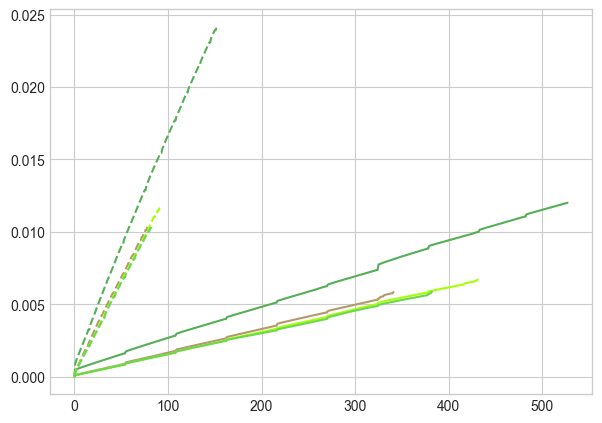

In [33]:
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,5))
for i in range(numrs):
    ax.plot(torch.cat(data_refs[i]["times"]),color=COLORS[i]);
    ax.plot(torch.cat(datas[i]["times"]),color=COLORS[i],linestyle="--");

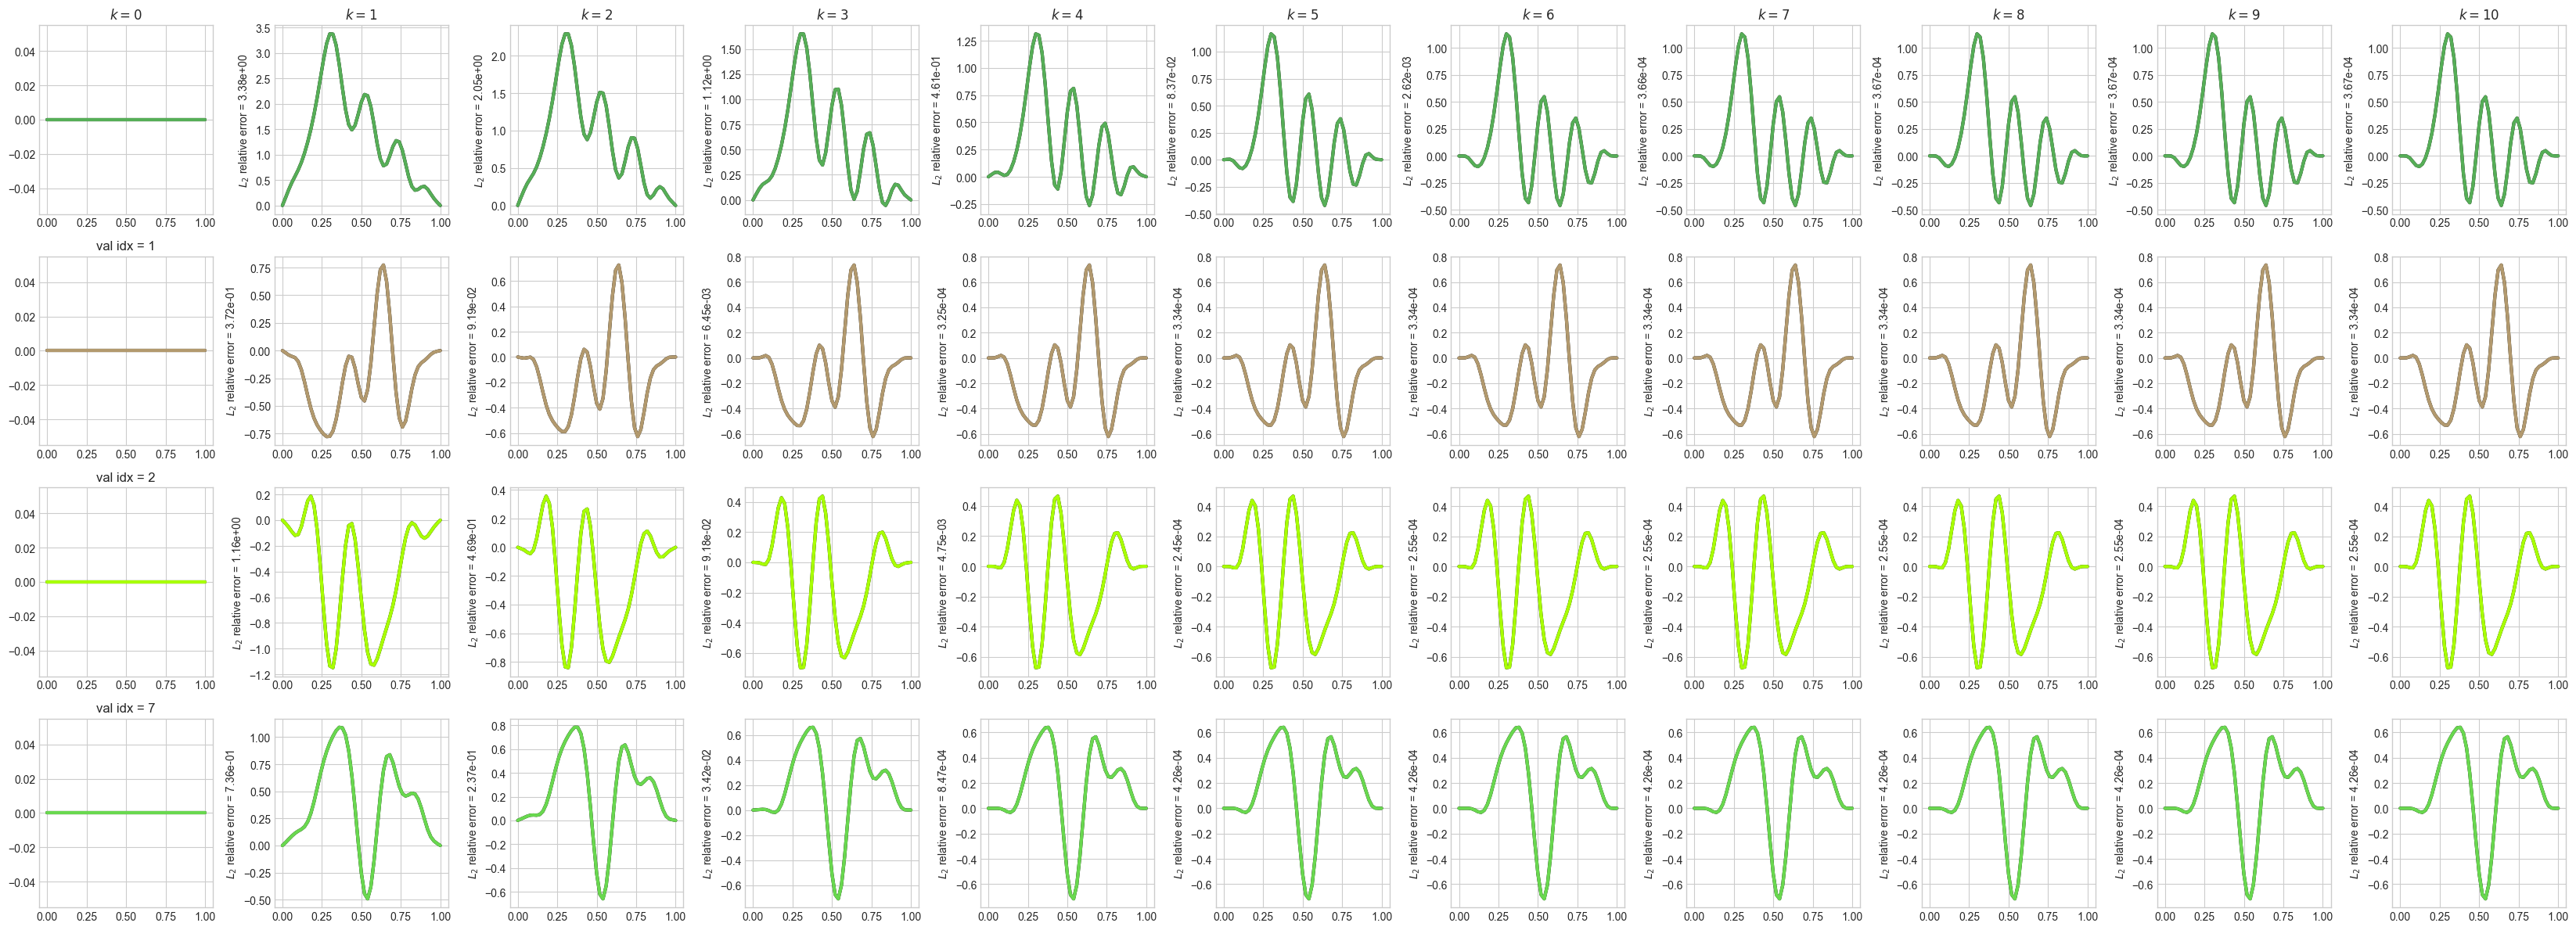

In [34]:
fig,ax = pyplot.subplots(nrows=numrs,ncols=numpreds,figsize=(3*numpreds,3*numrs))
for i in range(numrs):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat.min(),vhat.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(numpreds):
        ax[i,k].plot(xticks,vopt_val[ridxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        #ax[i,k].set_ylim([yymin,yymax])
        if k>0:
            ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(numrs):
    ax[i,0].set_title("val idx = %d"%ridxs[i])
for k in range(numpreds):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()

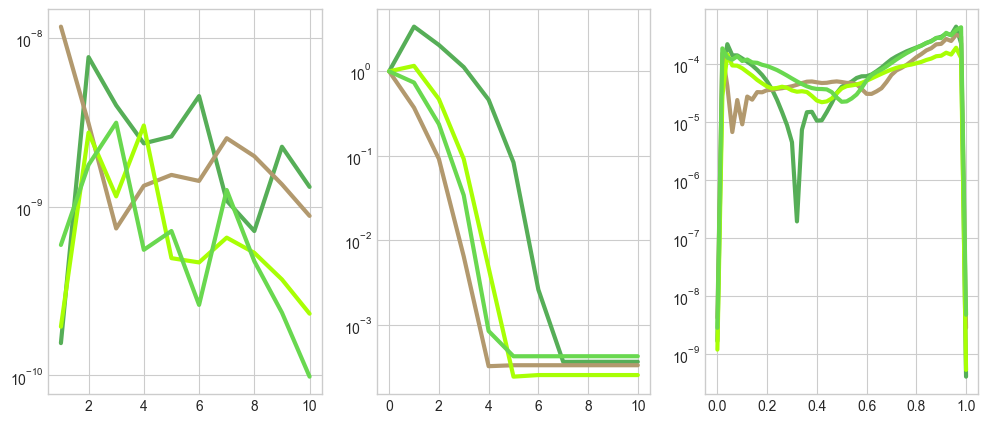

In [35]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=((12,5)))
for i in range(numrs):
    ax[0].plot(torch.arange(numpreds),l2rerrors_iter[i],linewidth=LW,color=COLORS[i])
    ax[1].plot(torch.arange(numpreds),l2rerrors[i],linewidth=LW,color=COLORS[i])
    ax[2].plot(xticks,aerrors[i],linewidth=LW,color=COLORS[i])
for i in range(3):
    ax[i].set_yscale("log",base=10)

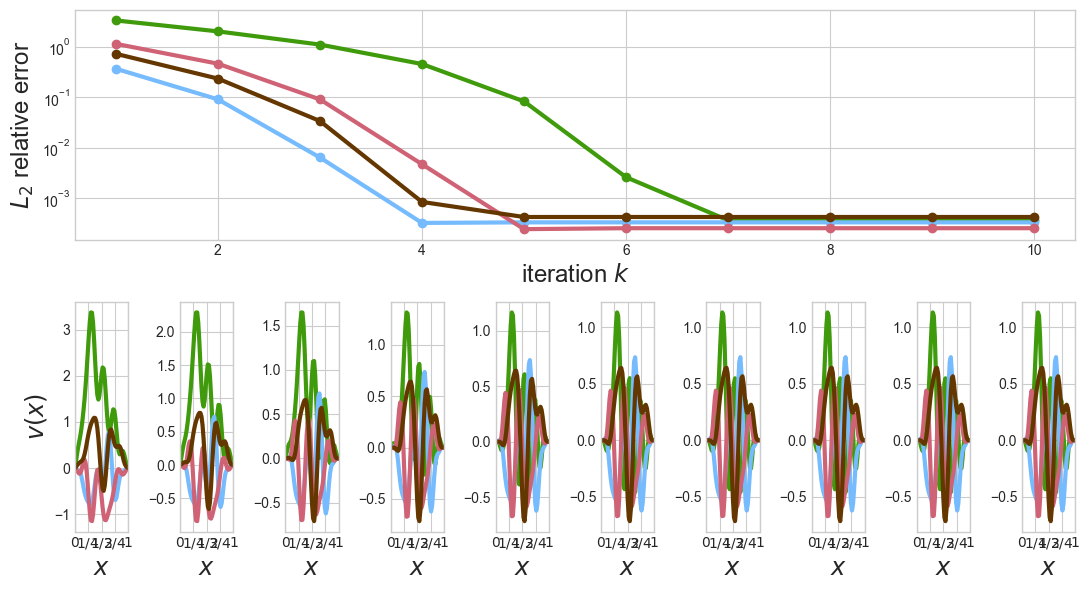

In [36]:
fig = pyplot.figure(figsize=(11,6))
_gs = gridspec.GridSpec(2,numpreds-1) 
CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
ax = fig.add_subplot(_gs[0,:])
for i in range(numrs):
    ax.plot(torch.arange(1,numpreds),l2rerrors[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
ax.set_yscale("log",base=10)
ax.set_xlim([.6,numpreds-.6])
ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
ax = np.empty(numpreds-1,dtype=object)
for k in range(numpreds-1):
    ax[k] = fig.add_subplot(_gs[1,k])
    ax[k].set_xlim([0,1])
    ax[k].set_xticks([0,1/4,1/2,3/4,1])
    ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    #ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
    ax[k].set_xlabel(r"$x$",fontsize="xx-large")
ymin,ymax = vhat[:,1:numpreds,:nxticks].min(),vhat[:,1:numpreds,:nxticks].max()
for k in range(numpreds-1):
    for i in range(numrs):
        ax[k].plot(xticks,vhat[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
for k in range(1,numpreds-1):
    pass#ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
fig.tight_layout()
#fig.savefig("./superres.png",dpi=512,bbox_inches="tight")